In [1]:
import numpy as np
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

/opt/anaconda3/envs/bf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def distance_matrix_jax(x1, x2):
    # x1: [N, D], x2: [M, D] => returns [N, M]
    diff = x1[:, None, :] - x2[None, :, :]
    return jnp.sqrt(jnp.sum(diff**2, axis=-1))

def exponential_covariance_jax(x1, x2, lengthscale=1.0, variance=1.0):
    x1 = jnp.array(x1)
    x2 = jnp.array(x2)
    dists = distance_matrix_jax(x1, x2)
    return variance * jnp.exp(-dists / lengthscale)

# -------------------------------------------------------------------
# Data generation
# -------------------------------------------------------------------
rng_key = random.PRNGKey(0)
grid_size = 10  # 10x10 grid = 100 points
x = np.stack(np.meshgrid(np.linspace(0, 10, grid_size), 
                        np.linspace(0, 10, grid_size)), -1).reshape(-1, 2)
n = x.shape[0]  # Should be 100


lengthscale_true = 2.0
variance_true = 2.0
cov_matrix_np = variance_true * np.exp(-cdist(x, x) / lengthscale_true)
y_latent = np.random.multivariate_normal(mean=np.zeros(n), cov=cov_matrix_np)

# Poisson outcome
y = np.random.poisson(lam=np.exp(y_latent))

# Introduce missing values
obs_idx = np.random.choice(n, size=int(0.7 * n), replace=False)
miss_idx = np.setdiff1d(np.arange(n), obs_idx)

x_obs = x[obs_idx]
y_obs = y[obs_idx]

# -------------------------------------------------------------------
# Geostat model with Poisson likelihood
# -------------------------------------------------------------------
def geostat_model(x_obs=None, y_obs=None, x_miss=None):
    # Sample hyperparams
    lengthscale = numpyro.sample("lengthscale", dist.LogNormal(0.0, 1.0))
    variance    = numpyro.sample("variance", dist.LogNormal(0.0, 1.0))

    # If we have observed data locations, build a GP for them
    if x_obs is not None:
        obs_dim = x_obs.shape[0]
        cov_obs = exponential_covariance_jax(x_obs, x_obs, lengthscale, variance)
        gp_obs  = numpyro.sample(
            "gp_obs",
            dist.MultivariateNormal(loc=jnp.zeros(obs_dim), covariance_matrix=cov_obs)
        )

        # If we also have y_obs, sample from Poisson
        if y_obs is not None:
            lam_obs = jnp.exp(gp_obs)
            numpyro.sample("y_obs", dist.Poisson(lam_obs), obs=y_obs)
    else:
        # No observed data => no obs GP
        gp_obs = None

    # If missing locations are supplied, compute conditional GP
    if x_miss is not None:
        miss_dim  = x_miss.shape[0]
        cov_miss  = exponential_covariance_jax(x_miss, x_miss, lengthscale, variance)

        if gp_obs is not None:
            # cross-cov
            cov_obs  = exponential_covariance_jax(x_obs, x_obs, lengthscale, variance)
            cross_cov = exponential_covariance_jax(x_miss, x_obs, lengthscale, variance)
            # conditional mean
            conditional_mean = jnp.dot(
                cross_cov, jnp.linalg.solve(cov_obs, gp_obs)
            )
            # conditional covariance
            conditional_cov = cov_miss - jnp.dot(
                cross_cov, jnp.linalg.solve(cov_obs, cross_cov.T)
            )
        else:
            # If there's no gp_obs, then missing is just the unconditional GP
            conditional_mean = jnp.zeros(miss_dim)
            conditional_cov  = cov_miss

        # We only sample the latent GP for missing data here
        gp_miss = numpyro.sample(
            "gp_miss",
            dist.MultivariateNormal(conditional_mean, covariance_matrix=conditional_cov)
        )

# -------------------------------------------------------------------
# MCMC on observed data
# -------------------------------------------------------------------
nuts_kernel = NUTS(geostat_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(rng_key, x_obs=x_obs, y_obs=y_obs, x_miss=x[miss_idx])
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 1500/1500 [00:13<00:00, 114.95it/s, 15 steps of size 2.20e-01. acc. prob=0.92]


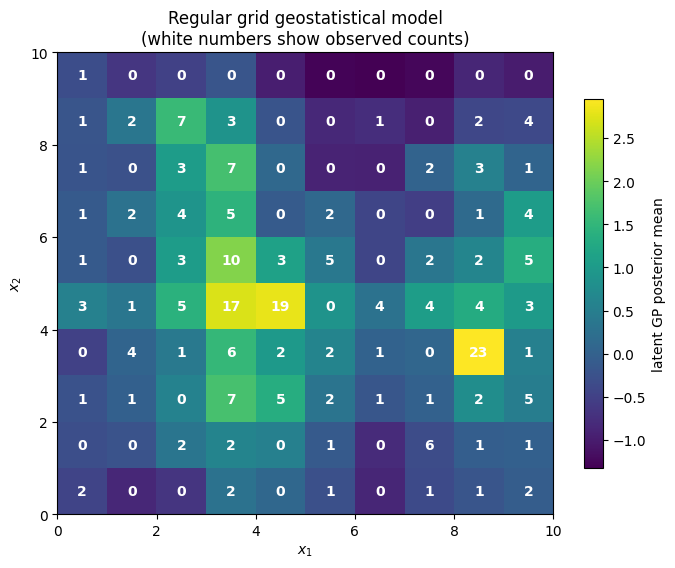

In [3]:
# -------------------------------------------------------------------
# Posterior predictive for missing data
# We'll get gp_miss from the model, then do Poisson draws manually.
# Because we called return_sites=['gp_miss'], the model won't 
# attempt to sample y_obs, which is None in the predictive call.
# -------------------------------------------------------------------
predictive = Predictive(geostat_model, posterior_samples, return_sites=["gp_miss"])
post_pred = predictive(rng_key, x_obs=x_obs, y_obs=None, x_miss=x[miss_idx])
gp_miss_samples = post_pred["gp_miss"]

# Generate Poisson draws for missing data
y_miss_stack = jnp.stack([random.poisson(random.fold_in(rng_key, i), jnp.exp(gp_miss_samples[i])) 
                         for i in range(gp_miss_samples.shape[0])], axis=0)

# Create full arrays
gp_full_mean = np.zeros(n)
gp_full_mean[obs_idx] = posterior_samples['gp_obs'].mean(0)
gp_full_mean[miss_idx] = gp_miss_samples.mean(0)

# -------------------------------------------------------------------
# Grid-based visualization
# -------------------------------------------------------------------
# Reshape results back to grid
grid_shape = (grid_size, grid_size)
latent_grid = gp_full_mean.reshape(grid_shape)
obs_mask = np.isin(x, x_obs).all(axis=1).reshape(grid_shape)

# Create plot
plt.figure(figsize=(8, 6))
plt.imshow(latent_grid, origin='lower', extent=[0, 10, 0, 10], 
          cmap='viridis', aspect='auto')
plt.colorbar(label='latent GP posterior mean', shrink=0.8)

# Add observed values as text
for i in range(grid_size):
    for j in range(grid_size):
        if obs_mask[i, j]:
            plt.text(j*(10/grid_size)+0.5, i*(10/grid_size)+0.5, 
                    f"{y.reshape(grid_shape)[i, j]}", 
                    ha='center', va='center', color='w', fontweight='bold')

plt.title('Regular grid geostatistical model\n(white numbers show observed counts)')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

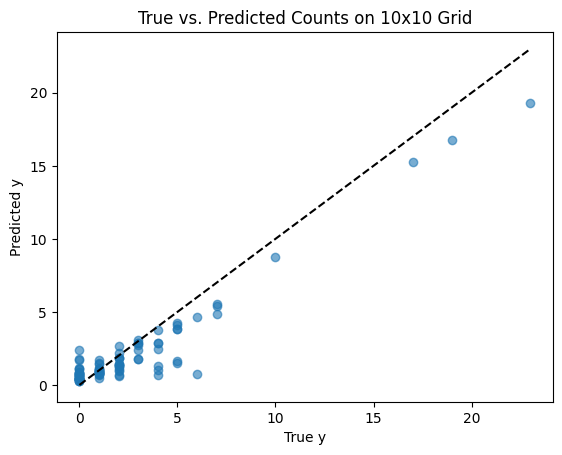

In [12]:
y_pred_mean = np.exp(gp_full_mean)

plt.figure()
plt.scatter(y, y_pred_mean, alpha=0.6)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("True vs. Predicted Counts on 10x10 Grid")
plt.plot([0, max(y)], [0, max(y)], 'k--')  # diagonal line for reference
plt.show()